# Practical 1: Multi-Layer Perceptrons

**Open notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/asci_cbl_practicals/blob/main/notebooks/1_MLPs.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/asci_cbl_practicals/blob/main/notebooks/1_MLPs.ipynb)    
**Authors:** Phillip Lippe

In this practical, you will get a first experience in working with images and neural networks by implementing multi-layer perceptrons (MLPs). You will experiment with different optimization and regularization strategies to get the best performance out of your model, and investigate the limitations of using MLPs for image processing. This notebook is intended to guide you through the practical and you can edit it in any place. If you prefer working with standard python scripts, feel free to convert this notebook into a python script. To open this notebook on Google Colab, use the button above. Note that you need to copy this notebook into your own Google Drive to save the notebook and trained models. Otherwise, your progress will be lost when you close the browser tab.

First of all, let's start with importing some standard libraries:

In [40]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
sns.set()

#added
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

Throughout the practicals, we make use of several datasets and might want to save different models. For this, we define the two paths below. Adjust the paths as you like, but remember to keep them consistent across practicals to not download the dataset several times.

In [41]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/practical1"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

Training deep neural networks is a stochastic process. Hence, every time you run the notebook, you naturally get different results. To obtain reproducible results, it is highly recommended to set a seed for all stochastic operations. Hence, let's define a `set_seed` function below.

In [42]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


Finally, let's start with setting up the dataset we will use in this practical: CIFAR10. CIFAR10 is a very popular dataset for computer vision on low-resolution images (32x32 pixels). The task is to classify images into one of 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Our goal is to develop a neural network that can solve this task efficiently and accurately. To load the dataset, we can luckily make use of PyTorch's library `torchvision` which provides access to many popular vision datasets and more practical functions. So, let's load the dataset below:

In [77]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

# Transformations are applied on images when we want to access them. Here, we push the images into a tensor
# and normalize the values. However, you can use more transformations, like augmentations to prevent overfitting.
# Feel free to experiment with augmentations here once you have a first running MLP, but remember to not apply
# any augmentations on the test data!
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])


#Augmented data
# Enhanced Data Augmentation
data_transforms_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    transforms.RandomCrop(32, padding=4),  # Random cropping with padding
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD)  # Normalize to zero mean and unit std
])

# Update training dataset with augmented transforms
#train_set_augmented = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms_augmented, download=True)
#train_loader_augmented = data.DataLoader(train_set_augmented, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)


# Loading the training dataset. We need to split it into a training and validation part
main_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms, download=True)
train_set, val_set = torch.utils.data.random_split(main_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=data_transforms, download=True)

# Create data loaders for later
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


When working with data, it is always recommend to look at the data before blaming your model for not performing well if the data was incorrectly processed. Hence, let's plot the first 10 images of the CIFAR10 training dataset:

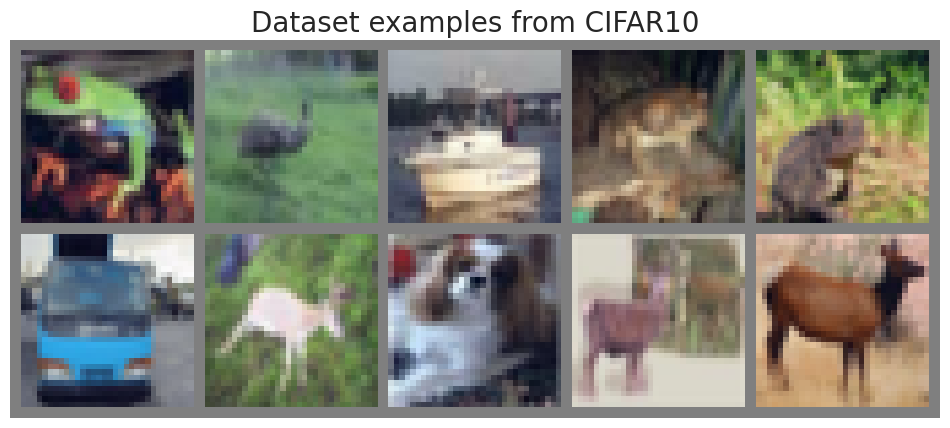

In [44]:
NUM_IMAGES = 10
images = [train_set[idx][0] for idx in range(NUM_IMAGES)]
img_grid = torchvision.utils.make_grid(torch.stack(images, dim=0), nrow=5, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,8))
plt.title("Dataset examples from CIFAR10", fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Now we are all set. So, let's dive into implementing our own MLP!

## Part 1: Implementing the MLP

As a first step, let's implement a simple MLP.

### MLP Module

You can make use of PyTorch's common functionalities, especially the `torch.nn` modules might be of help. The design choices of the MLP (e.g. the activation function) is left up to you, but for an initial setup, we recommend stacking linear layers with ReLU activation functions in between. Remember to not apply any activation function on the output.

In [45]:


class MLP(nn.Module):
    def __init__(self, input_size=3072, num_classes=10, hidden_sizes=[256, 128]):
        """
        Inputs:
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_sizes - A list of integers specifying the hidden layer sizes in the MLP.
                           The MLP should have len(hidden_sizes)+1 linear layers.
        """
        super(MLP, self).__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        current_size = input_size  # Input size for the first layer

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size

        # Output layer
        layers.append(nn.Linear(current_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Ensure the input is [batch_size, input_size]
        return self.network(x)


In [61]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size=3072, num_classes=10, hidden_sizes=[256, 128]):
        super(ImprovedMLP, self).__init__()
        layers = []
        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))  # Dropout for regularization
            current_size = hidden_size

        layers.append(nn.Linear(current_size, num_classes))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.network(x)

# Model initialization
#model = ImprovedMLP(input_size=32 * 32 * 3, num_classes=10, hidden_sizes=[512, 256, 128])
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # Add weight decay


In [78]:
class ImprovedMLPWithBatchNorm(nn.Module):
    def __init__(self, input_size=3072, num_classes=10, hidden_sizes=[512, 256, 128]):
        super(ImprovedMLPWithBatchNorm, self).__init__()
        layers = []
        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))  # Dropout for regularization
            current_size = hidden_size

        layers.append(nn.Linear(current_size, num_classes))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.network(x)

# Model initialization
#model = ImprovedMLPWithBatchNorm(input_size=32 * 32 * 3, num_classes=10, hidden_sizes=[512, 256, 128])


In [63]:
# Let's test the MLP implementation
input_size = np.random.randint(low=64, high=3072)
num_classes = np.random.randint(low=5, high=20)
hidden_sizes = [np.random.randint(low=32, high=256) for _ in range(np.random.randint(low=1, high=3))]
my_mlp = MLP(input_size=input_size, num_classes=num_classes, hidden_sizes=hidden_sizes)
my_mlp.to(device)
random_input = torch.randn(32, input_size, device=device)
random_output = my_mlp(random_input)
assert random_output.shape[0] == random_input.shape[0]
assert random_output.shape[1] == num_classes

### Optimizer

To gain a better insight in the training of the neural networks, let's implement our own optimizer. First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps.

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function `zero_grad` sets the gradients of all parameters to zero, which we have to do before calling `loss.backward()`. Finally, the `step()` function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [64]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD) with momentum. Plain SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

The concept of momentum replaces the gradient in the update by an exponential average of all past gradients including the current one, which allows for a smoother training. The gradient update with momentum becomes:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's implement the optimizer below:

In [65]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.9):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        # TODO: Implement the gradient update
        #raise NotImplementedError
        """
        Updates the parameter `p` using SGD with momentum.
        """
        if p.grad is None:
            return  # Skip if there is no gradient

        # Retrieve the current and previous momentum
        m_t = self.param_momentum[p]

        # Compute the momentum update
        m_t.mul_(self.momentum).add_(p.grad, alpha=1 - self.momentum)  # m(t) = β1 * m(t-1) + (1-β1) * g(t)

        # Update the parameter
        p.data.add_(m_t, alpha=-self.lr)  # w(t) = w(t-1) - η * m(t)

        # Store the updated momentum
        self.param_momentum[p] = m_t

    def step(self):
        """
        Perform a single optimization step.
        """
        for p in self.params:
            self.update_param(p)

To verify that our optimizer is working, let's create a challenging surface over two parameter dimensions which we want to optimize to find the optimum:

In [66]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

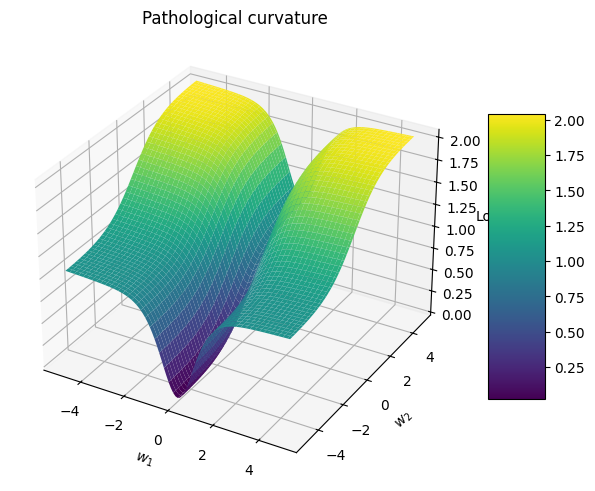

In [67]:
def plot_curve_0(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection='3d') if plot_3d else fig.gca()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y], indexing='ij')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

def plot_curve(curve_fn, x_range=(-5, 5), y_range=(-5, 5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))
    # Use add_subplot instead of gca()
    ax = fig.add_subplot(111, projection='3d') if plot_3d else fig.add_subplot(111)

    x = torch.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / 100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / 100.)
    x, y = torch.meshgrid([x, y], indexing='ij')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        surf = ax.plot_surface(x, y, z, cmap=cmap, linewidth=0, antialiased=True)
        ax.set_zlabel("Loss")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))

    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [68]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        # TODO: Determine the loss for the current weights, save the weights and loss, perform backpropagation
        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Compute the loss
        w1, w2 = weights[0], weights[1]
        loss = curve_func(w1, w2)

        # Save the current weights and loss
        list_points.append(torch.tensor([w1.item(), w2.item(), loss.item()]))

        # Perform backpropagation
        loss.backward()
        optimizer.step()
        #raise NotImplementedError

    points = torch.stack(list_points, dim=0).numpy()
    return points

Next, let's apply the optimizer on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [69]:
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

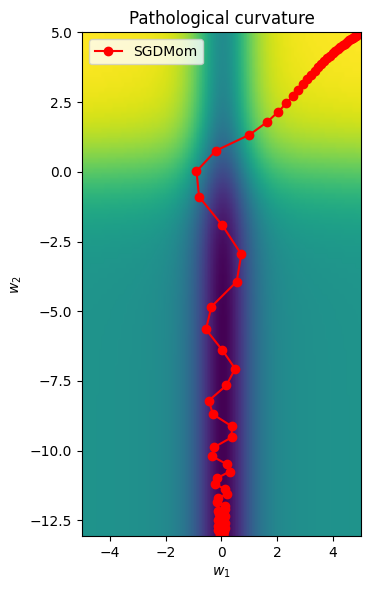

In [70]:
all_points = SGDMom_points
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="red", marker="o", zorder=2, label="SGDMom")
plt.legend()
plt.show()

If the implementation is correct, you should see that the optimizer indeed reaches a point of very low $w_2$ ($w_2 < -7.5$) and $w_1\approx 0$. If not, go back to your optimizer implementation and check what could go wrong.

### Training and validation function

Now that we the MLP ready, the optimizer implemented, and the dataset loaded, we can look at implementing our own training function. The form of the training function is left mostly up to you, but we recommend that you test the model on the validation function after every 5 epochs, and save the best model. We provide a rough template below.

In [80]:
def train_model_0(model, optimizer, train_data_loader, val_data_loader, num_epochs=25, model_name="MyMLP"):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs+1):
        model.train()

        running_loss = 0.0  # Track loss for each epoch

        for imgs, labels in train_data_loader:
          # TODO: Implement training loop with training on classification
            imgs, labels = imgs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(imgs)

            # Compute loss
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch}/{num_epochs}, Loss: {running_loss / len(train_data_loader):.4f}")




        # Validate every 5 epochs
        if epoch % 5 == 0:
            val_acc = test_model(model, val_data_loader)  # Evaluate on validation set
            print(f"Validation Accuracy: {val_acc:.2f}%")

            # Save the model if it's the best so far
            if val_acc > best_val_acc:
                print("Saving best model...")
                best_val_acc = val_acc
                save_model(model, model_name)


    # Load best model after training
    load_model(model, model_name)



def train_model(model, optimizer, train_data_loader, val_data_loader, num_epochs=25, model_name="MyMLP"):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0  # Initialize the best validation accuracy

    for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track loss for the epoch

        # Training loop
        for imgs, labels in train_data_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(imgs)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        print(f"Epoch {epoch}/{num_epochs}, Loss: {running_loss / len(train_data_loader):.4f}")

        # Evaluate and save the model every 5 epochs
        if epoch % 5 == 0:
            val_acc = test_model(model, val_data_loader)  # Compute validation accuracy
            print(f"Validation Accuracy: {val_acc:.2f}%")

            if val_acc > best_val_acc:  # Save the model if validation improves
                print("Saving the best model...")
                best_val_acc = val_acc
                save_model(model, model_name)
                test_accuracy = test_model(model, test_loader)
                print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Load the best model after training
    load_model(model, model_name)


In [72]:
@torch.no_grad()
def test_model(model, data_loader):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total  # Calculate accuracy
    return accuracy

In [73]:
def save_model(model, model_name):
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, f"{model_name}.pth"))
    print(f"Model saved to {CHECKPOINT_PATH}/{model_name}.pth")

def load_model(model, model_name):
    model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f"{model_name}.pth")))
    print(f"Model loaded from {CHECKPOINT_PATH}/{model_name}.pth")


In [ ]:
# Initialize the MLP model
input_size = 32 * 32 * 3  # CIFAR-10 images
num_classes = 10

#model = MLP(input_size=input_size, num_classes=num_classes, hidden_sizes=[256, 128])

# Optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


model = ImprovedMLPWithBatchNorm(input_size=32 * 32 * 3, num_classes=10, hidden_sizes=[512,256, 128])
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # Add weight decay

# Train the model
train_model(model, optimizer, train_loader, val_loader, num_epochs=40, model_name="MyMLP")




Epoch 1/40, Loss: 1.9300
Epoch 2/40, Loss: 1.7783
Epoch 3/40, Loss: 1.7184
Epoch 4/40, Loss: 1.6824
Epoch 5/40, Loss: 1.6516
Validation Accuracy: 45.02%
Saving the best model...
Model saved to ../saved_models/practical1/MyMLP.pth
Test Accuracy: 44.89%
Epoch 6/40, Loss: 1.6267
Epoch 7/40, Loss: 1.6118
Epoch 8/40, Loss: 1.5972
Epoch 9/40, Loss: 1.5678
Epoch 10/40, Loss: 1.5708
Validation Accuracy: 47.42%
Saving the best model...
Model saved to ../saved_models/practical1/MyMLP.pth
Test Accuracy: 47.80%
Epoch 11/40, Loss: 1.5575
Epoch 12/40, Loss: 1.5452
Epoch 13/40, Loss: 1.5359
Epoch 14/40, Loss: 1.5264
Epoch 15/40, Loss: 1.5172
Validation Accuracy: 49.22%
Saving the best model...
Model saved to ../saved_models/practical1/MyMLP.pth
Test Accuracy: 49.03%
Epoch 16/40, Loss: 1.5146
Epoch 17/40, Loss: 1.4999
Epoch 18/40, Loss: 1.4942
Epoch 19/40, Loss: 1.4890
Epoch 20/40, Loss: 1.4798
Validation Accuracy: 50.06%
Saving the best model...
Model saved to ../saved_models/practical1/MyMLP.pth
Tes

In [76]:
# Test the best model on the test set
test_accuracy = test_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 54.44%


It is expected that you reach with the default configurations a validation and test accuracy of $\sim52-53\%$ . If you have reached this performance, we can consider this task as completed!

## Part 2: Improving your MLP

Now that we have a basic MLP, let's try to improve over this default performance! Your task is to think about ways to maximize the performance of your MLP. Possible suggestions you can look at include:

* Do data augmentations help the model to generalize?
* Can regularization techniques (dropout, weight decay, etc.) help?
* Do deeper models perform better? Or is it better to have wide networks?
* Can normalization techniques (BatchNorm, LayerNorm, etc.) help?

Your task is to improve your model to reach at least 56% on the test set! But can you get even above this? Consider this as a challenge!

For this implementation, you can directly edit your model above. In your report, list the changes that you have made and discuss what affect they have. Further, repeat the experiment for *at least 3 seeds* to report stable improvements.

In [ ]:
# TODO: Improve the model
raise NotImplementedError

## Part 3: Investigating the limitations

Now that we have seen how we can optimize our MLP, it is good to investigate the limitations of the model as well. Images have a natural grid structure where close-by pixels are strongly related. Does the MLP make use of this structure? To investigate this question, we will run two experiments:

* Create a shuffle of pixels at the beginning of the training, and use the same shuffle throughout the training and validation.
* At each training and validation step, sample a new shuffle of pixels.


It is up to you whether you perform this investigation on the original plain MLP version or your optimized one. Implement a corresponding train and test function that support both variants of shuffling, and train two models.

In [ ]:
import torch

def fixed_shuffle(image, permutation):
    """
    Applies a fixed pixel permutation to the input image.
    Args:
        image (torch.Tensor): Input image tensor of shape (C, H, W).
        permutation (torch.Tensor): Permutation indices.
    Returns:
        torch.Tensor: Shuffled image tensor.
    """
    return image.view(-1)[permutation].view(image.shape)

def random_shuffle(image):
    """
    Applies a random pixel permutation to the input image.
    Args:
        image (torch.Tensor): Input image tensor of shape (C, H, W).
    Returns:
        torch.Tensor: Shuffled image tensor.
    """
    permutation = torch.randperm(image.numel())
    return image.view(-1)[permutation].view(image.shape)


In [ ]:
# TODO: Create a training and test function that supports the shuffling of pixels, both fixed and newly generated for each batch
def train_with_shuffling(model, optimizer, train_loader, val_loader, shuffle_mode="fixed", num_epochs=25, model_name="ShuffledMLP"):
    """
    Train the model with pixel shuffling.
    Args:
        model: The MLP model.
        optimizer: The optimizer for training.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        shuffle_mode: "fixed" or "random" pixel shuffling.
        num_epochs: Number of training epochs.
        model_name: Name for saving the model.
    """
    # Generate a fixed permutation if needed
    fixed_permutation = torch.randperm(32 * 32 * 3).to(device) if shuffle_mode == "fixed" else None

    model.to(device)
    best_val_acc = -1.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Apply shuffling
            if shuffle_mode == "fixed" and fixed_permutation is not None:
                imgs = torch.stack([fixed_shuffle(img, fixed_permutation) for img in imgs])
            elif shuffle_mode == "random":
                imgs = torch.stack([random_shuffle(img) for img in imgs])

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

        # Validate every 5 epochs
        if epoch % 5 == 0:
            val_acc = test_with_shuffling(model, val_loader, shuffle_mode, fixed_permutation)
            print(f"Validation Accuracy: {val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_model(model, model_name)

    load_model(model, model_name)


@torch.no_grad()
def test_with_shuffling(model, data_loader, shuffle_mode="fixed", fixed_permutation=None):
    """
    Test the model with pixel shuffling.
    Args:
        model: The MLP model.
        data_loader: DataLoader for the test/validation set.
        shuffle_mode: "fixed" or "random" pixel shuffling.
        fixed_permutation: Fixed permutation for shuffling.
    Returns:
        float: Accuracy on the dataset.
    """
    model.eval()
    correct = 0
    total = 0

    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Apply shuffling
        if shuffle_mode == "fixed" and fixed_permutation is not None:
            imgs = torch.stack([fixed_shuffle(img, fixed_permutation) for img in imgs])
        elif shuffle_mode == "random":
            imgs = torch.stack([random_shuffle(img) for img in imgs])

        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return 100 * correct / total


In [ ]:
# TODO: Create model, optimizer, and start training on fixed shuffling of pixels
# Fixed Shuffle
model_fixed = MLP(input_size=32 * 32 * 3, num_classes=10, hidden_sizes=[512, 256, 128])
optimizer_fixed = optim.SGD(model_fixed.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
train_with_shuffling(model_fixed, optimizer_fixed, train_loader, val_loader, shuffle_mode="fixed", model_name="FixedShuffledMLP")




In [ ]:
# TODO: Create model, optimizer, and start training on a new shuffling of pixels per batch/image
# Random Shuffle
model_random = MLP(input_size=32 * 32 * 3, num_classes=10, hidden_sizes=[512, 256, 128])
optimizer_random = optim.SGD(model_random.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
train_with_shuffling(model_random, optimizer_random, train_loader, val_loader, shuffle_mode="random", model_name="RandomShuffledMLP")

What results do you observe? What does this tell us about the MLP being aware of the image structure? Add your results and observations to your report.

## Conclusion

You have reached the end of the practical, congratulations! Now, you should have a good idea of what it means to train a MLP, how we can use neural networks to perform image classification, and what tricks there are to improve a networks performance. In the next practicals, we will look at more advanced network structures beyond MLPs.